# 1. Seminarska naloga

Avtorji: Mark Tič, Jaka Vodlan, Mark Mihelič

Prvo importamo potrebne knjižnice.

In [1]:
import numpy as np
import pandas as pd
import random
import math
import copy
from sympy import sympify, simplify
from matplotlib import pyplot as plt

Definiramo možne operatorje in vrednosti kot globalne spremenljivke.

In [2]:
digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
operators = ['+', '-', '*', '/', '**'] # Operators with both left and right child
operatorsC = ['log'] # Complex operators (log: left - expression, right - base)
trigonometric = ['sin', 'cos'] # Trigonometric operators, only have left child

Definiramo dve globalni zastavici.

In [3]:
complex_expressions = False # Flag for including more complex operations (eksponential function, log, sin, cos...)
invalid_expression = False # Flag for invalid expressions (dividing with 0, complex numbers, negative value in log...)

Vsak izraz je predstavljen z drevesom, v katerem je vsaka točka razreda TreeNode.

In [4]:
class TreeNode:
    def __init__(self, value):
        self.value = str(value)
        self.left = None
        self.right = None
        
    def __eq__(self, other):
        # Check if both nodes are None (base case)
        if self is None and other is None:
            return True
        # Check if one node is None and the other is not (different structure)
        if (self is None and other is not None) or (self is not None and other is None):
            return False
        # Compare values and recursively compare left and right subtrees
        return (
            self.value == other.value and
            self.left == other.left and
            self.right == other.right
        )
    
    def __hash__(self):
        # Convert the tree structure into a hashable representation (tuple)
        return hash((self.value, self.left, self.right))

Funkcija, ki zgenerira naključno drevo, maximalne višine max_height.

Pri enostavnejših izrazih, ko niso vključene kompleksnejše operacije so omejitve naslednje:
- Če je operator '\*\*' (potenca), potem mora biti desni otrok nujno števka. Če je hkrati tudi levi otrok števka, jo spremenimo v x, da se izognemo operaciji števka\*\*števka
- Če sta oba sinova neke točke lista, mora biti eden nujno x drugi pa števka, da ne pride do operacij oblike x$x ali števka$števka ($ je operator)

Pri kompleknsejših izrazih, ko so vključene tudi kompleknejše operacije pa so omejitve naslednje:
- Če je operator '\*\*' (potenca) in levi sin 1, spremenimo levi sin v drugo števko, da ne pride do operacije oblike 1\*\*nekaj.
- Če je operator 'log', je desni sin (osnova) števka večja od 1, e ali pa 10.
- Če je operator 'sin' ali 'cos', potem ima točka le levega sina.
- Če sta oba sinova neke točke lista, mora biti eden nujno x drugi pa števka, da ne pride do operacij oblike x$x ali števka$števka ($ je enostaven operator).

In [5]:
def generate_random_tree(max_height, depth=0):
    global complex_expressions
    if random.random() < (1 / max_height) * depth:
        if random.choice([True, False]):
            return TreeNode(random.choice(digits))
        else:
            if complex_expressions:
                return TreeNode(random.choice(['x', 'e']))
            else:
                return TreeNode('x')
    if complex_expressions:
        operator = random.choice(operators + operatorsC + trigonometric)
        node = TreeNode(operator)
        node.left = generate_random_tree(max_height, depth + 1)
        if operator == '**' and node.left.value == '1':
            node.left.value = random.choice(digits[1:])
        if operator == 'log':
            node.right = TreeNode(random.choice(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'e']))
        elif operator != 'sin' and operator != 'cos':
            node.right = generate_random_tree(max_height, depth + 1)
            if node.left.value in digits + ['x', 'e'] and node.right.value in digits + ['x', 'e']:
                if node.value in '+*':
                    node.left.value = 'x'
                    node.right.value = random.choice(digits)
                elif node.value in '-/':
                    if random.choice([True, False]):
                        node.left.value = random.choice(['x', 'e'])
                        node.right.value = random.choice(digits)
                    else:
                        node.left.value = random.choice(digits)
                        node.right.value = random.choice(['x', 'e'])
                elif node.value == '**' and node.left.value in digits and node.right.value in digits:
                    node.right.value = random.choice(['x', 'e'])
        return node
    else:
        operator = random.choice(operators)
        node = TreeNode(operator)
        node.left = generate_random_tree(max_height, depth + 1)
        if operator == '**':
            if node.left.value in digits:
                node.left.value = 'x'
            node.right = TreeNode(random.choice(digits))
        else:
            node.right = generate_random_tree(max_height, depth + 1)
        if node.left.value.isalnum() and node.right.value.isalnum():
            if node.value in '+*':
                node.left.value = 'x'
                node.right.value = random.choice(digits)
            elif node.value in '-/':
                if random.choice([True, False]):
                    node.left.value = 'x'
                    node.right.value = random.choice(digits)
                else:
                    node.left.value = random.choice(digits)
                    node.right.value = 'x'
        return node

Funkcija, ki izpiše obliko drevesa.

In [6]:
def print_tree(root, level=0, prefix=""):
    if level == 0:
        print(prefix + str(root.value))
    else:
        print(" " * (level * 3) + prefix + str(root.value))
    if root.left is not None:
        print_tree(root.left, level + 1, "L: ")
    if root.right is not None:
        print_tree(root.right, level + 1, "R: ")

Funkcija, ki izpiše izraz v obliki stringa.

In [7]:
def print_expression(node):
    print_expression_rec(node)
    print()

def print_expression_rec(node):
    if complex_expressions and node is not None:
        if node.value == 'sin' or node.value == 'cos':
            print(node.value, end="(")
            print_expression_rec(node.left)
            print(")", end="")
        elif node.value == 'log':
            print(node.value, end="(")
            print_expression_rec(node.left)
            print(",", end="")
            print_expression_rec(node.right)
            print(")", end="")
        elif node.value in operators:
            print("(", end="")
            print_expression_rec(node.left)
            print(node.value, end="")
            print_expression_rec(node.right)
            print(")", end="")
        else:
            print(node.value, end="")
    elif node is not None:
        if node.value in operators:
            print("(", end="")
            print_expression_rec(node.left)
            print(node.value, end="")
            print_expression_rec(node.right)
            print(")", end="")
        else:
            print(node.value, end="")

def print_expressions(arr, new = True):
    if new:
        print("[", end="")
    print("\"", end="")
    print_expression_rec(arr[0])
    print("\"", end="")
    if len(arr) > 1:
        print(", ", end="")
        print_expressions(arr[1:], False)
    else:
        print("]")

Funkcija za izračun logaritma z podano osnovo.

In [8]:
def log_with_base(x, base):
    global invalid_expression
    if math.log(base) == 0:
        invalid_expression = True
        return 0
    if x <= 0:
        invalid_expression = True
        return 0
    return math.log(x) / math.log(base)

Funkcija, ki izračuna vrednost izraza pri določenem x.


In [9]:
def evaluate(node, x):
    global invalid_expression
    global complex_expressions
    if invalid_expression:
        invalid_expression = False
        return 0.0
    
    if node.left != None and node.right != None:
        if node.value == "**" and (node.left.value == "**" or node.right.value == "**"):
            invalid_expression = True
            return 0.0
    
    if node != None:
        if node.value in digits + ['x', 'e', '10']:
            if node.value == 'x':
                return x
            elif complex_expressions and node.value == 'e':
                return np.e
            return int(node.value)
        elif node.value in operators:
            if node.value == '+':
                return evaluate(node.left, x) + evaluate(node.right, x)
            elif node.value == '-':
                return evaluate(node.left, x) - evaluate(node.right, x)
            elif node.value == '*':
                return evaluate(node.left, x) * evaluate(node.right, x)
            elif node.value == '/':
                right = evaluate(node.right, x)
                if right == 0:
                    return 0.0
                return evaluate(node.left, x) / right
            elif node.value == '**':
                base = evaluate(node.left, x)
                if base < 0:
                    invalid_expression = True
                    return 0.0
                return base ** evaluate(node.right, x)
        elif node.value in operatorsC + trigonometric:
            if node.value == 'log':
                base = evaluate(node.right, x)
                if base <= 0:
                    return 0.0
                return log_with_base(evaluate(node.left, x), base)
            elif node.value == 'sin':
                angle = math.radians(evaluate(node.left, x))
                return math.sin(angle)
            elif node.value == 'cos':
                angle = math.radians(evaluate(node.left, x))
                return math.cos(angle)
    return None

Funkcija, ki ustvari novo operacijo višine ena iz nekega lista drevesa. Vrednost lista se nahaja v enem od sinov.

Pri enostavnejših izrazih, ko niso vključene kompleksnejše operacije so omejitve naslednje:
- Če je operator '\*\*' (potenca), potem mora biti levi sin nujno x, desni pa nujno števka
- Če sta oba sinova neke točke lista, mora biti eden nujno x drugi pa števka, da ne pride do operacij oblike x$x ali števka$števka ($ je operator)

Pri kompleknsejših izrazih, ko so vključene tudi kompleknejše operacije pa so omejitve naslednje:
- Če je operator 'log', je desni sin (osnova) števka večja od 1, e ali pa 10.
- Če je operator 'sin' ali 'cos', potem ima točka le levega sina.
- Če sta oba sinova neke točke lista, mora biti eden nujno x drugi pa števka, da ne pride do operacij oblike x$x ali števka$števka ($ je enostaven operator).

In [10]:
def generate_operation(node):
    if complex_expressions:
        operator = random.choice(operators + operatorsC + trigonometric)
        if operator in trigonometric:
            node.left = TreeNode(node.value)
            node.right = None
        else:
            if node.value in digits:
                if random.choice([True, False]) or operator == 'log':
                    node.left = TreeNode(random.choice(['x', 'e']))
                    node.right = TreeNode(node.value)
                    if operator == 'log' and node.right.value == '1':
                        node.right.value = '2'
                else:
                    node.left = TreeNode(node.value)
                    node.right = TreeNode(random.choice(['x', 'e']))
            else:
                if random.choice([True, False]) or operator == 'log':
                    node.left = TreeNode(node.value)
                    if operator == 'log':
                        node.right = TreeNode(random.choice(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'e']))
                    else:
                        node.right = TreeNode(random.choice(digits))
                else:
                    node.left = TreeNode(random.choice(digits))
                    node.right = TreeNode(node.value)
    else:
        operator = random.choice(operators)
        if node.value in digits:
            if random.choice([True, False]) or operator == '**':
                node.left = TreeNode('x')
                node.right = TreeNode(node.value)
            else:
                node.left = TreeNode(node.value)
                node.right = TreeNode('x')
        else:
            if random.choice([True, False]) or operator == '**':
                node.left = TreeNode('x')
                node.right = TreeNode(random.choice(digits))
            else:
                node.left = TreeNode(random.choice(digits))
                node.right = TreeNode('x')
    node.value = operator
    return node

Funkcija, ki pretvori točke drevesa v array, ter funkcija, ki v takem arrayu prešteje x vrednosti (število x vrednosti v izrazu).

In [11]:
def nodes_to_array(root):
    def in_order_traversal(node, result):
        if node is not None:
            in_order_traversal(node.left, result)
            result.append(node)
            in_order_traversal(node.right, result)

    result = []
    in_order_traversal(root, result)
    return result

def number_of_x_values(arr):
    return len([x for x in arr if x.value == "x"])

Funkcija, ki izvaja mutacije.

4 vrste mutacij:

1. change_operator: zamenja nek operator, kjer so potrebne naslednje omejitve:
    - Točka mora biti operator.
    - Operator 'sin' je lahko zamnejan le z operatorjem 'cos' in obratno.
    - Operator 'log' ne sme biti zamnejan z nobenim operatorjem.


2. change_operand: zamenja nek operand z drugim operandom (ni posebnih omejitev)

3. add_operation: zamenja nek list z novo operacijo, kjer je prejšnji list v enem izmed listov nove operacije.

4. remove_operation: odstrani neko operacijo (točko, pri kateri sta oba sinova lista) in jo nadomesti z enim od sinov listov.

Če je število x vrednosti v izrazu po mutaciji enako nič, označimo izraz za neveljaven (invalid).

In [12]:
def mutate(root, mutation_rate):
    global invalid_expression

    # print("Pred mutacijo: ")
    # print_expression(root)
    nodes_array = nodes_to_array(root)
    nodes_mutated = []
    if random.random() < mutation_rate:
        number_of_x = number_of_x_values(nodes_array)
        if number_of_x == len(nodes_array):
            mutation_type = random.choice(["change_operator", "add_operation", "remove_operation"])
        elif number_of_x >= 2:
            mutation_type = random.choice(["change_operator", "change_operand", "add_operation"])
        elif len(nodes_array) == 1:
            mutation_type = random.choice(["add_operation"])
        else:
            mutation_type = random.choice(["change_operator", "change_operand", "add_operation", "remove_operation"])
        # Filter nodes array based on mutation_type (example: if changing the operator, the selected node has to be operator => filter array to only include operator nodes)
        nodes_array_filtered = [x for x in nodes_array if
                        x not in nodes_mutated and
                        mutation_type == "change_operator" and x.value in operators or
                        mutation_type == "change_operand" and x.value in digits or
                        mutation_type == "add_operation" and x.value in digits + ['x'] or
                        mutation_type == "remove_operation" and x.value in operators and (((x.left == None) or (x.left != None and x.left.left == None)) and
                                                                                        ((x.right == None) or (x.right != None and x.right.right == None)))
                        ]
        if len(nodes_array_filtered) > 0:
            random_node = random.choice(nodes_array_filtered)
            if mutation_type == "change_operator":
                if random_node.value == 'sin':
                    random_node.value = 'cos'
                elif random_node.value == 'cos':
                    random_node.value = 'sin'
                elif random_node.value != 'log':
                    random_node.value = random.choice([x for x in operators if x != random_node.value])
            if mutation_type == "change_operand":
                random_node.value = random.choice([x for x in digits if x != random_node.value])
            if mutation_type == "add_operation":
                random_operation = generate_operation(random_node)
                random_node.value = random_operation.value
                random_node.left = random_operation.left
                random_node.right = random_operation.right
            if mutation_type== "remove_operation": # tuki je treba nardit se da bo nov value x alpa digit glede na to a je na drugi strani enacbe x alpa digit (bi rabl mogoce node.parent)
                random_node.value = random.choice([random_node.left.value, random_node.right.value])
                random_node.left = None
                random_node.right = None
            
            nodes_mutated.append(random_node)

    # print("Po: ")
    # print_expression(root)
    if number_of_x_values(nodes_to_array(root)) == 0:
        # return mutate(root, mutation_rate)
        invalid_expression = True
    return root

Funkcija, ki naredi kopijo drevesa.

In [13]:
def tree_copy(root):
    if root is None:
        return None

    new_root = TreeNode(root.value)
    new_root.left = tree_copy(root.left)
    new_root.right = tree_copy(root.right)

    return new_root

Funkcija, ki opravlja crossover.

Crossover je pri genetskih algoritmih pomemben del implementacije saj z njim dosežemo raznolikost ter nove in boljše potomce v tem primeru naših dreves ki predstavljajo matematične izraze. Pri implementaciji je seveda možnih več načinov ki se v večini razlikujejo po tem v kakšni strukturi smo ta expression shranili lahko pa tudi v tem na koliko točkah bomo naredili crossover oziroma Koliko potomcev bi radi v končnem produktu dobili.
 
Naša prva zamisel ki nam je najprej padla na pamet je bila da oba parent expressiona pretvorimo v string ter določimo točko kjer se bosta dela teh dveh stringvov križala. Ta implementacija se je izkazala za prepočasno saj je v bistvu pretvarjanje iz drevesa v string in nazaj povzročalo težave ne samo časovno ampak tudi z vrstnimi redi operacij in podobnimi zadevami.

Druga implementirana metoda obe drevesi pretvori v array vozljišč ter izračuna crossover točko ki se nahaja nekje v krajšem izmed dveh arrayev. Child array potem sestavi iz vozljišč ki so deli prvga starša ter se nahajajo pred crossover točko. Po tej točki vzame vozlišča še iz drugega starša. Kot rezultat sedaj dobimo mešanico prvega in drugega starša ki pa ga vrnemo kot drevo.
 
Trenutna implementirana metoda (in po našem mnenju tudi optimalna) je da v staršeskem drevesu poiščemo nek crossover point ter tisto vozljišče zamnjamo z nekim vozljiščem iz drugega poddrevesa. Po časovni zahtevnosti bi morala biti ta metoda najhitrejša saj ne opravlja nobenih pretvorb med strukturami naredi rekoč samo prevez med vozljišči oziroma v najslabšem primeru skopira del drugega poddrevesa ter ga pripne prvemu. 


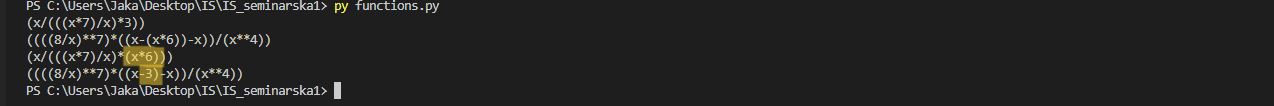 

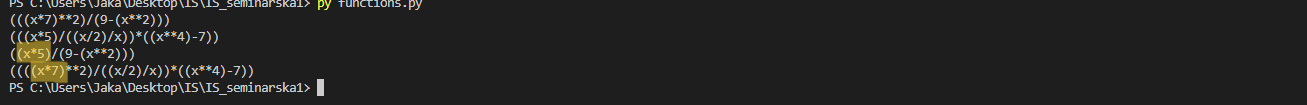 

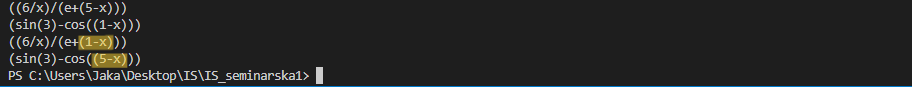

In [14]:
def crossover(parent1, parent2):
    # Create deep copies of the parents to avoid modifying them directly
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    # Select a non-root node from parent1
    parent1_node = get_random_non_root_node(parent1)
    # Select a non-root node from parent2
    parent2_node = get_random_non_root_node(parent2)

    # Swap the selected nodes and their descendants
    swap_nodes(child1, parent1_node, parent2_node)

    # Swap the selected nodes and their descendants in the second child
    swap_nodes(child2, parent2_node, parent1_node)

    return child1, child2

def get_random_non_root_node(tree):
    # Get a list of all non-root nodes in the tree
    non_root_nodes = get_non_root_nodes(tree)

    # Select a random non-root node
    return random.choice(non_root_nodes)

def get_non_root_nodes(node):
    # Helper function to get a list of all non-root nodes in the tree
    non_root_nodes = []
    if node.left:
        non_root_nodes.append(node.left)
        non_root_nodes.extend(get_non_root_nodes(node.left))
    if node.right:
        non_root_nodes.append(node.right)
        non_root_nodes.extend(get_non_root_nodes(node.right))
    return non_root_nodes

def swap_nodes(tree, node1, node2):
    # Helper function to swap two nodes and their descendants in the tree
    if tree is None:
        return

    if tree == node1:
        # Replace node1 with a deep copy of node2
        tree.value = node2.value
        tree.left = copy.deepcopy(node2.left)
        tree.right = copy.deepcopy(node2.right)
    else:
        # Recursively swap nodes in the left and right subtrees
        swap_nodes(tree.left, node1, node2)
        swap_nodes(tree.right, node1, node2)

Helper functions.

In [15]:
def expressionsAreRepeating(population):
    for i in range(len(population)):
        for j in range(len(population)):
            if isEqual(population[i], population[j]):
                return True   
    return False
            
def isEqual(e1, e2):
    if e1 == None and e2 == None:
        return True
    if (e1.value != e2.value):
        return False
    return isEqual(e1.left, e2.left) and isEqual(e1.right, e2.right)

def uniqueExpressions(population):
    expressions = [x[1] for x in population]
    for i in range(len(expressions)):
        for j in range(len(expressions)):
            if isEqual(expressions[i], expressions[j]):
                del population[j]
                return uniqueExpressions(population)
    return population


Funkcija za poenostavljanje izraza.

Ker smo tekom izdelave seminarske naloge naleteli na težavo ki je bila v dolžini expressionov oziroma velikosti the dreves smo se odločili implementirati način oziroma funkcijo v katero podamo izrazno drevo, ta pa nam drevo parsa v string katerega format je ustrezen za delo v sympy knjižnici. Ta knjižnica se okvarja z matematičnimi izrazi med drugimi tudi z okrajšavo le teh. Na ta način smo dobili expression ki je po vrednosti enak prejšnjemu, po dolžini pa bistveno krajši.

In [16]:
def expression_to_string_rec(node):
    result = ""
    if complex_expressions and node is not None:
        if node.value == 'sin' or node.value == 'cos':
            result += node.value + "("
            result += expression_to_string_rec(node.left)
            result += ")"
        elif node.value == 'log':
            result += "log("
            result += expression_to_string_rec(node.left)
            result += ", "
            result += expression_to_string_rec(node.right)
            result += ")"
        elif node.value in operators:
            result += "("
            result += expression_to_string_rec(node.left)
            result += node.value
            result += expression_to_string_rec(node.right)
            result += ")"
        else:
            result += node.value
    elif node is not None:
        if node.value in operators:
            result += "("
            result += expression_to_string_rec(node.left)
            result += node.value
            result += expression_to_string_rec(node.right)
            result += ")"
        else:
            result += node.value
    return result

def simplify_tree(tree_to_simp):
    s = expression_to_string_rec(tree_to_simp)
    simp = sympify(s)
    simp1 = simplify(simp)
    print(simp1)

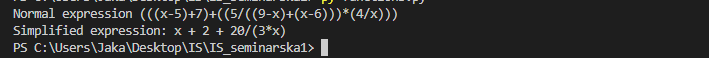 

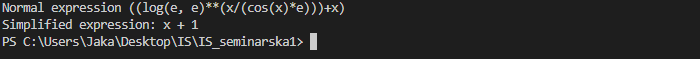

# UVOD

1. Uvozimo knjižnice, ki jih uporabljamo.
2. Preberemo testne podatke (data.csv) na katerih treniramo naš model.
3. Nastavimo parametre, ki jih lahko spreminjamo po volji, ki upravljajo delovanje našega modela
Med pomembnejšimi so:
    - population_size = kako velika bo populacija v vsaki generaciji
    - max_generations = koliko je število generacij, ki se izvedejo
    - number_of_parents = koliko enačb iz prejšnje generacije bomo vzeli za starše naslednje generacije
    - fitness_weight = kolikšna je utež pri uporabi različnih fitness funkcij

In [17]:
# from functions import *
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import time

solution = ""

row_indices = [29, 30, 45]
# row_indices = [48]
number_of_examples = len(row_indices)
df = pd.read_csv("data.csv")
x_values_arrays = [df["Xs"].iloc[index] for index in row_indices]
y_values_arrays = [df["Ys"].iloc[index] for index in row_indices]
correct_solutions = [df["Equation"].iloc[index] for index in row_indices]
calculated_solutions = []
x_values = [np.array(eval(x_values_arr)) for x_values_arr in x_values_arrays]
y_values = [np.array(eval(y_values_arr)) for y_values_arr in y_values_arrays]
example_index = 0

all_best_fitness_scores = [[] for _ in range(number_of_examples)]
all_mutation_rates = [[] for _ in range(number_of_examples)]
all_durations = [0 for _ in range(number_of_examples)]
fresh_parents_to_add = 0

fitness_weight = 0.05
population_size = 50
max_generations = 2500
base_mutation_rate = 0.2
number_of_parents = 20
max_base_population_tree_height = 1
debugging_mode = True

# Fitness funkcije

Imamo dve glavni fitness funkciji, ki jih lahko uporabimo posamično ali pa skupaj z določleno utežjo med njima. 

1. fitness1() je preprosta funkcija,
ki izračuna razliko med dobljeno y vrednostjo in dejansko y vrednostjo in jo kvadrira, ter vzame mediano vseh - mse.

2. fitness2() je funkcija, ki dela podobno kot fitness1(), le da izračuna ne le razliko med dobljeno in želeno vrednostjo y, vendar vzame hkrati po dve x vrednosti, izračuna y na obeh, in nato najprej izračuna razliko med dobljenima in nato želenima y. Nato pa še razliko med dobljeno in želeno razliko, ki jo potem tudi kvadrira in vzame mediano. Pravzaprav gre za podobno funkcijo, le da ne gleda dejanskih vrednosti in izračuna absolutno napako, vendar gleda za koliko se je y spremenil npr. iz x = 1 na x = 2 in za koliko bi se moral.

Na začetku smo implementirali le fitness1(), ki pa se za nekatere izraze ni obnesel. Tak izraz je npr. (x / 5) + 9:

Če potem testiramo npr. izraz x / 5 je napaka večja kot, če bi testirali x / 3, kar pa ni idealno, saj je x / 5 dejansko bližje rešitvi. To naključje drži ravno na intervalu x = [1, 100], kjer smo testirali. Ker je x / 3 bližje je težje priti do x / 5 + 9, saj potrebujemo 2 mutaciji.

Tako se je rodila ideja za drugo fitnes funkcijo opisano zgoraj.

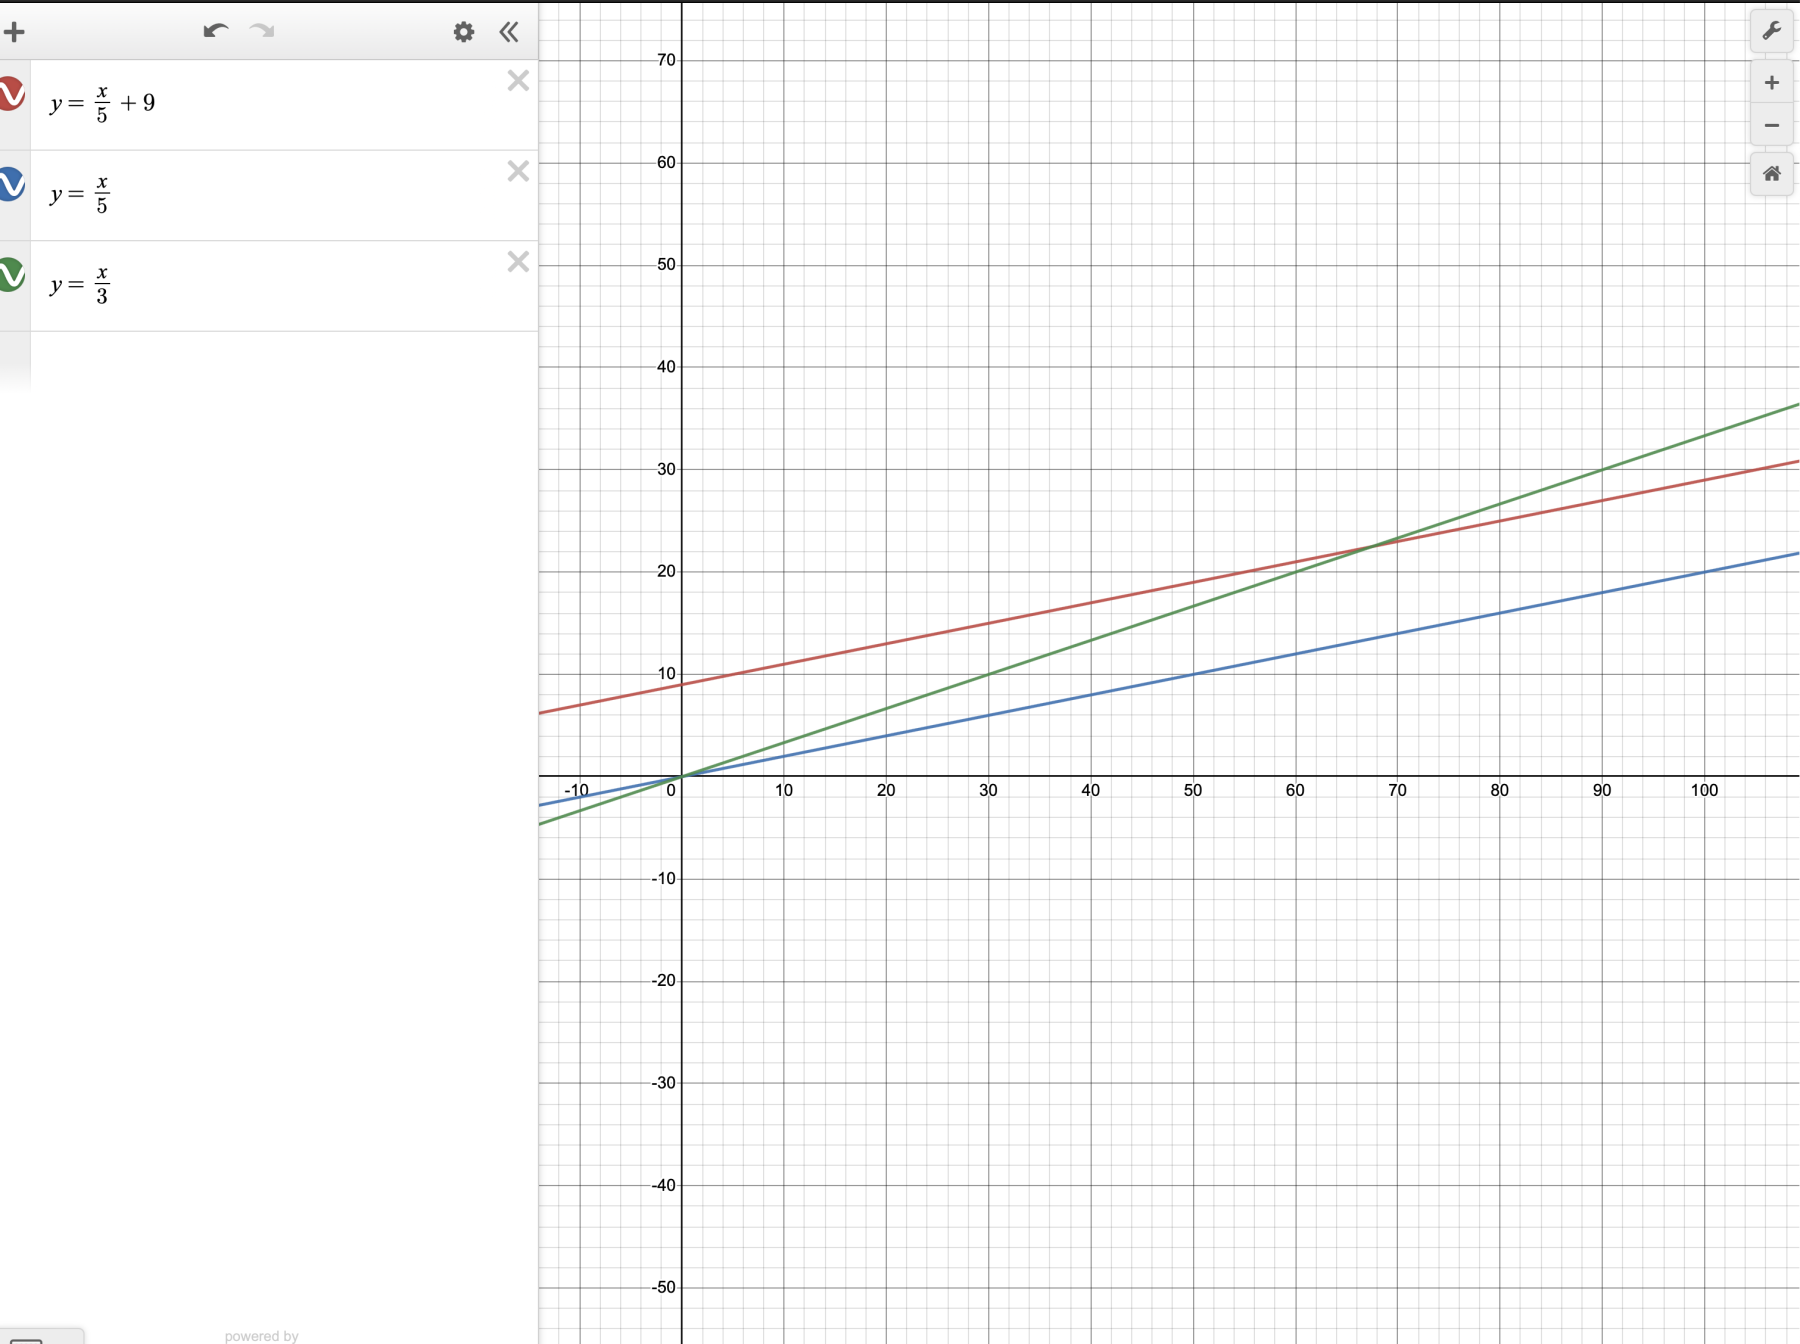

In [18]:
def fitness1(expression):
    try:
        predicted_y = [evaluate(expression, xi) for xi in x_values[example_index].tolist()]
        dif_squared_arr = []
        for i in range(len(y_values[example_index])):
            if predicted_y[i] > 10000000000:
                return (-1.0, expression)
            dif_squared = np.power((predicted_y[i] - y_values[example_index][i]), 2)
            dif_squared_arr.append(dif_squared)
        mse = np.mean(np.array(dif_squared_arr))
        if mse > 10000000000:
            return (-3.0, expression)
        return (1.0 / (mse + 1e-6), expression)  # Avoid division by zero
    except Exception as e:
        return (-2.0, expression)  # Return a low fitness for invalid expressions
    
def fitness2(expression):
    try:
        predicted_y = [evaluate(expression, xi) for xi in x_values[example_index].tolist()]
        dif_squared_arr = []
        for i in range(len(y_values[example_index]) - 1):
            if predicted_y[i] > 10000000000:
                return (-1.0, expression)
            predicted_dif = predicted_y[i + 1] - predicted_y[i]
            actual_dif    = y_values[example_index][i + 1] - y_values[example_index][i]
            dif_squared = np.power((predicted_dif - actual_dif), 2)
            dif_squared_arr.append(dif_squared)
        mse = np.mean(np.array(dif_squared_arr))
        if mse > 10000000000:
            return (-3.0, expression)
        return (1.0 / (mse + 1e-6), expression)  # Avoid division by zero
    except Exception as e:
        return (-2.0, expression)  # Return a low fitness for invalid expressions

# Glavni algoritem

mutation_rate je prilagodljiva spremenljivka, ki se spreminja glede na to ali smo že dolgo na isti enačbi oz. se najboljši fitness score iz generacije v generacijo ne spremeni. Graf tudi pokaže spreminjanje te spremenljivke.

Poizkusili smo uporabiti konstanten mutation_rate, ki pa se ni obnesel tako dobro kot prilagodljivi. Poizkusili smo tudi mutation_rate, ki se ne prilagaja algoritmu, vendar je na začetku visok, nato pa se zmanjša, da ko se bližamo rešitvi mutacije niso več tako pogoste.



In [19]:
while example_index < number_of_examples:
    
    start_time = time.time()
    
    # Ponastavi mutation_rate in generiraj prvo generacijo
    mutation_rate = base_mutation_rate
    population = []
    population += [generate_random_tree(max_base_population_tree_height) for _ in range(population_size)]
    
    for generation in range(max_generations):
        
        all_mutation_rates[example_index].append(mutation_rate)
        
        fitness_scores1 = [fitness1(individual) for individual in population]
        fitness_scores2 = [fitness2(individual) for individual in population]
        
        fitness_scores = []
        for i in range(len(fitness_scores1)):
            weighted_score = (fitness_weight * fitness_scores1[i][0] + (1 - fitness_weight) * fitness_scores2[i][0], fitness_scores2[i][1])
            fitness_scores.append(weighted_score)

        # Izberi najboljše enačbe za starše naslednje generacije
        selected_parents = sorted(fitness_scores, key=lambda x: x[0], reverse=True)[:number_of_parents]
        selected_parents = list(set(selected_parents))
        
        # Prilagodi mutation_rate, glede na to ali smo že predolgo na isti enačbi (smo malo stuck)
        for i in range(len(all_best_fitness_scores[example_index])):
            if i > 10:
                break
            if selected_parents[0][0] == all_best_fitness_scores[example_index][-i]:
                if mutation_rate + 0.03 <= 1:
                    mutation_rate = mutation_rate + 0.03                
            else:
                if mutation_rate - 0.03 >= 0:
                    mutation_rate = mutation_rate - 0.03
            if mutation_rate > 0.7:
                fresh_parents_to_add += 1
                
        if len(all_best_fitness_scores[example_index]) == 0 or fitness_scores[0][0] >= all_best_fitness_scores[example_index][-1]:
            all_best_fitness_scores[example_index].append(fitness_scores[0][0])

        # Če je najdena prava enačba lahko zaključimo (1000000.0, ker uporabljamo 1/(mse+1e-6) kot našo fitness vrednost
        # Kadar je mse = 0.0, bo fitness 1000000.0)
        if selected_parents[0][0] == 1000000.0:
            population = [x[1] for x in selected_parents]
            calculated_solutions.append(population[0])
            simplify_tree(population[0])
            break

        new_population = [t[1] for t in selected_parents]
        
        # Dodaj nove sveže kratke enačbe, ampak samo ko smo že predolgo na isti enačbi
        for i in range(fresh_parents_to_add):
            new_population.append(generate_random_tree(1))
            fresh_parents_to_add = 0

        i = 0
        # Zgradi novo generacijo enakomerno iz staršev iz prejšnje (crossover, mutate)
        while len(new_population) < population_size:

            if i + 1 < len(new_population):
                
                child1 = tree_copy(new_population[i])
                child2 = tree_copy(new_population[i + 1])
                
                if (child1.left != None and child1.right != None and child2.left != None and child2.right != None):
                    child1, child2 = crossover(child1, child2)

                child1 = mutate(child1, mutation_rate)
                child2 = mutate(child2, mutation_rate)
                new_population.append(child1)
                new_population.append(child2)
                
                if i + 2 >= number_of_parents:
                    i = 0
                else:
                    i += 2
            
            else:
                child = tree_copy(new_population[i])
            
                child = mutate(child, mutation_rate)

                new_population.append(child)

                if i + 1 >= number_of_parents:
                    i = 0
                else:
                    i += 1

        population = new_population
    
    if len(calculated_solutions) != example_index + 1:
        calculated_solutions.append(population[0])
        
    end_time = time.time()
    all_durations[example_index] = end_time - start_time
        
    example_index += 1

x/9
x/5 + 9
9*x + 117


# Prikaži rezultate

Prvi graf prikazuje

Dobljena enačba:
x/9
Pravilna enačba:
(x / 9)
Čas izvajanja: 0.12604522705078125s


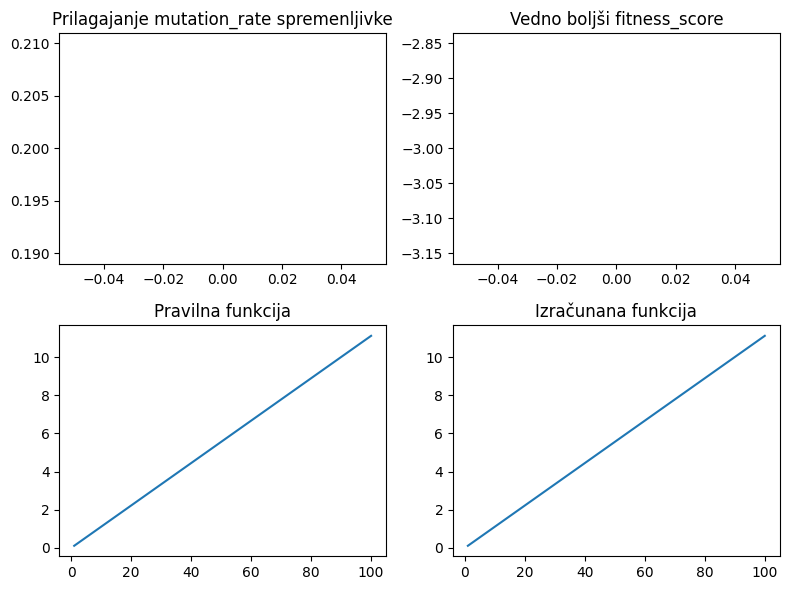

Dobljena enačba:
x/5 + 9
Pravilna enačba:
((x / 5) + 9)
Čas izvajanja: 57.006105184555054s


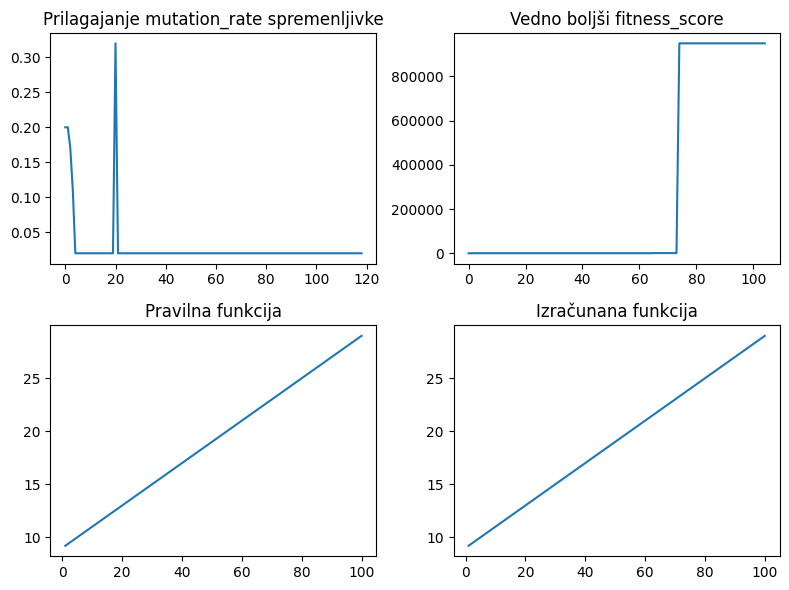

Dobljena enačba:
9*x + 117
Pravilna enačba:
(((x + 7) + 6) * 9)
Čas izvajanja: 7.8442840576171875s


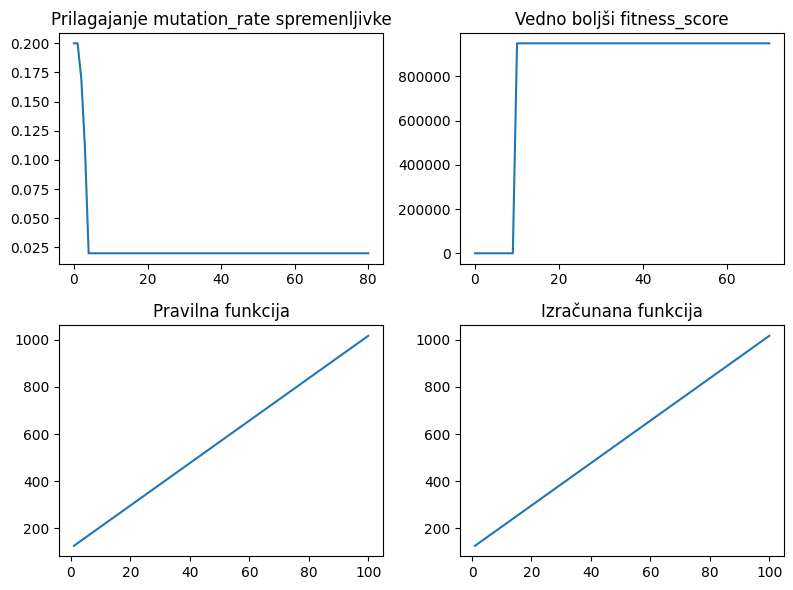

In [20]:
example_index = 0
while example_index < number_of_examples:

    print("Dobljena enačba:")
    simplify_tree(calculated_solutions[example_index])
    print("Pravilna enačba:")
    print(correct_solutions[example_index])
    
    print("Čas izvajanja: ", end="")
    print(str(all_durations[example_index]) + "s")

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)
    plt.plot(range(len(all_mutation_rates[example_index])), all_mutation_rates[example_index])
    plt.title('Prilagajanje mutation_rate spremenljivke')

    plt.subplot(2, 2, 2)
    plt.plot(range(len(all_best_fitness_scores[example_index])), all_best_fitness_scores[example_index])
    plt.title('Vedno boljši fitness_score')
    
    plt.subplot(2, 2, 3)
    plt.plot(x_values[example_index], y_values[example_index])
    plt.title('Pravilna funkcija')
    
    plt.subplot(2, 2, 4)
    plt.plot(x_values[example_index], [evaluate(calculated_solutions[example_index], x) for x in x_values[example_index]])
    plt.title('Izračunana funkcija')

    plt.tight_layout()
    plt.show()
    
    example_index += 1